In [31]:
import sys
sys.path.append('../')

import gzip
import json
from pathlib import Path
from dataclasses import dataclass
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
import seaborn as sns
from pocketknife.database import connect_database, read_from_database
from ftlangdetect import detect

from success_prediction.config import EXTERNAL_DATA_DIR, RAW_DATA_DIR, PROCESSED_DATA_DIR
from success_prediction.rag_components.cleanup import MarkdownCleaner

# SODC DATA STRUCTURE ANALYSIS

In [37]:
df = pd.read_csv(EXTERNAL_DATA_DIR / 'sodc_data_summary.csv')

In [84]:
# Find the number of shab entries requiring partial llm-parsing
partial_llm_parsing = df.groupby('shab_id')['llm_parsed'].max().reset_index()
partial_llm_parsing['llm_parsed'].sum()

445393.0

In [86]:
445393 / 2464085

0.18075391068084096

In [85]:
partial_llm_parsing

,shab_id,llm_parsed
0,2636071,1.0
1,2636073,0.0
2,2636075,0.0
3,2636077,0.0
4,2636079,0.0
...,...,...
2464080,1006273239,1.0
2464081,1006273250,1.0
2464082,1006273261,0.0
2464083,1006273283,0.0


In [38]:
year_total = df.groupby(['year', 'language'])['llm_parsed'].count().reset_index()
year_sum = year_total.groupby('year')['llm_parsed'].sum().reset_index().rename(columns={'llm_parsed': 'total'})
year_total = year_total.merge(year_sum, on='year')
year_total['percentage'] = year_total['llm_parsed'] / year_total['total']
year_language = df.groupby(['year', 'language'])['llm_parsed'].mean().reset_index()
canton = df.groupby(['registry_office_canton'])['llm_parsed'].mean().reset_index()
year_canton = df.groupby(['year', 'registry_office_canton'])['llm_parsed'].mean().reset_index()

In [76]:
average_per_language = df.groupby(['language'])['llm_parsed'].mean().reset_index()
average_per_language

,language,llm_parsed
0,de,0.058085
1,fr,0.111148
2,it,0.069025


In [78]:
year_total['llm_parsed'].sum()

7366993

In [79]:
year_total

,year,language,llm_parsed,total,percentage
0,2016,de,471801,657409,0.717667
1,2016,fr,130435,657409,0.198408
2,2016,it,55173,657409,0.083925
3,2017,de,524317,739185,0.709318
4,2017,fr,154186,739185,0.208589
5,2017,it,60682,739185,0.082093
6,2018,de,533876,746577,0.715098
7,2018,fr,156733,746577,0.209935
8,2018,it,55968,746577,0.074966
9,2019,de,558989,776488,0.719894


In [2]:
import numpy as np

mpl.rcParams.update({
    "font.family": "serif",
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10
})

def custom_line_plot(ax, df, x_col, y_col, v_col, add_trend=True):
    pivot_df = df.pivot(index=x_col, columns=y_col, values=v_col)

    for column in pivot_df.columns:
        x = pivot_df.index.values
        y = pivot_df[column].values

        # Plot the actual line
        ax.plot(
            x, y, marker='o', label=column,
            linewidth=1, markersize=2
        )

        # Add trend line (linear fit)
        if add_trend and len(x) > 1 and not np.all(np.isnan(y)):
            # Remove NaNs
            valid = ~np.isnan(y)
            if valid.sum() >= 2:
                coeffs = np.polyfit(x[valid], y[valid], deg=1)
                trend = np.poly1d(coeffs)
                ax.plot(
                    x, trend(x), linestyle='--', linewidth=0.75,
                    alpha=0.5,
                )

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.tick_params(direction='in', top=False, right=False)
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return ax

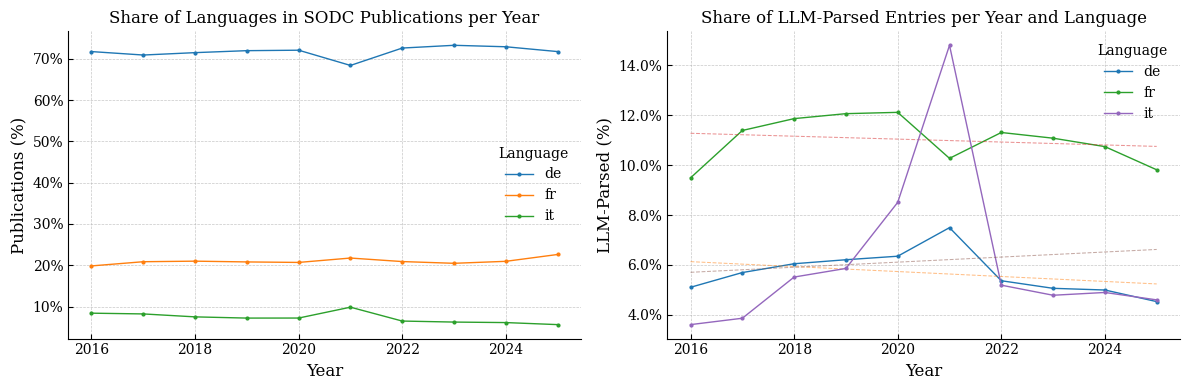

In [102]:
fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)  # Approx A4 column width

axes[0] = custom_line_plot(axes[0], year_total, 'year', 'language', 'percentage', add_trend=False)
axes[1] = custom_line_plot(axes[1], year_language, 'year', 'language', 'llm_parsed')

axes[0].set_title('Share of Languages in SODC Publications per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Publications (%)')
axes[0].legend(title='Language', frameon=False)

axes[1].set_title('Share of LLM-Parsed Entries per Year and Language')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('LLM-Parsed (%)')
axes[1].legend(title='Language', frameon=False)

plt.tight_layout()
plt.savefig('../reports/figures/summary_line_charts.png')

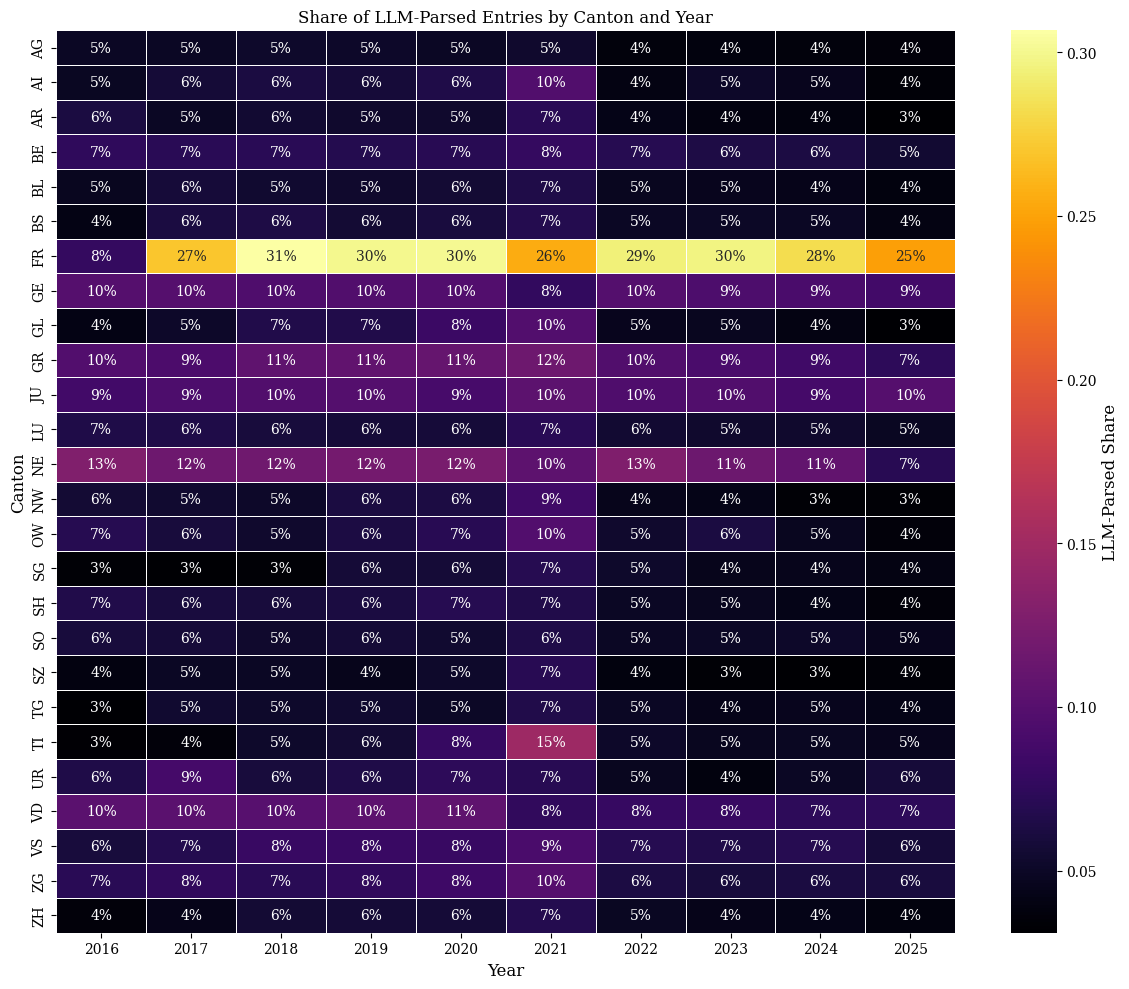

In [ ]:
pivot_df = year_canton.pivot(index='registry_office_canton', columns='year', values='llm_parsed')
fig, ax = plt.subplots(figsize=(12, 10))

# Create heatmap
sns.heatmap(
    pivot_df,
    cmap="inferno",  # Clean and journal-appropriate
    ax=ax,
    linewidths=0.5,
    linecolor='white',
    annot=True,             # Annotate cells with values
    fmt=".0%",              # Format as percentage
    cbar_kws={'label': 'LLM-Parsed Share'},
    vmin=min(pivot_df.values.flatten()),
    vmax=max(pivot_df.values.flatten())
)

# Axis labels and formatting
ax.set_title("Share of LLM-Parsed Entries by Canton and Year")
ax.set_xlabel("Year")
ax.set_ylabel("Canton")

# Tight layout for publication
plt.tight_layout()
plt.savefig('../reports/figures/summary_heatmap.png')

# WEBSITE SUMMARY STATISTICS

In [ ]:
query_merger = """ 
    SELECT ehraid_acquirer, ehraid_acquiree, merger_date, name_similarity FROM zefix.merger_relation;
"""

with connect_database() as con:
    df_merger = read_from_database(connection=con, query=query_merger)

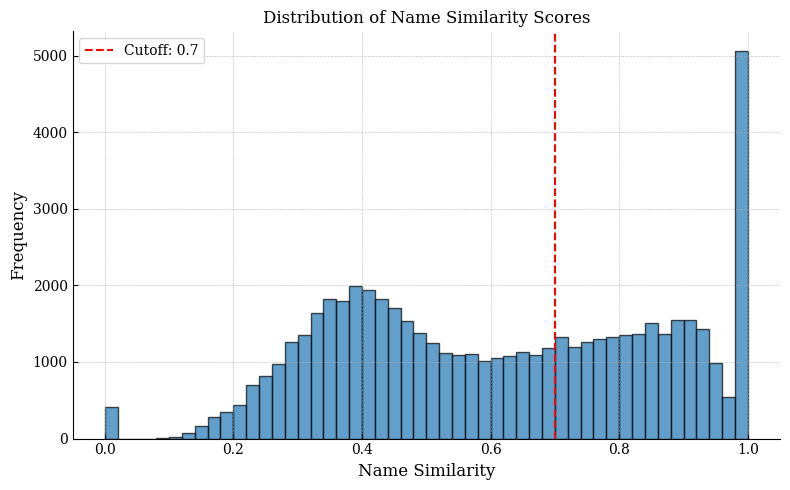

In [13]:
def plot_name_similarity_distribution(df, column='name_similarity', bins=50, cutoff=None):
    fig, ax = plt.subplots(figsize=(8,5))
    
    ax.hist(df[column], bins=bins, edgecolor='k', alpha=0.7)
    ax.set_title('Distribution of Name Similarity Scores')
    ax.set_xlabel('Name Similarity')
    ax.set_ylabel('Frequency')

    ax.tick_params(direction='in', top=False, right=False)
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if cutoff is not None:
        ax.axvline(cutoff, color='red', linestyle='--', label=f'Cutoff: {cutoff}')
        ax.legend()
        
    plt.tight_layout()
    plt.show()

plot_name_similarity_distribution(df_merger, cutoff=0.7)

## WEBSITE DISTRIBUTION

In [ ]:
# Set kind to either current or wayback
KIND = 'wayback'

In [ ]:
@dataclass
class Clients:
    md_cleaner: MarkdownCleaner

clients = Clients(
    md_cleaner=MarkdownCleaner()
)

def load_raw_file(file_path: Path) -> dict:
    """
    Loads a gzipped JSON file and returns its content as a dictionary.

    Args:
        file_path (Path): Path to the gzipped JSON file.

    Returns:
        dict: Parsed JSON data.
    """
    with gzip.open(file_path, 'r') as f:
        return json.load(f)


def most_common(lst):
    return max(set(lst), key=lst.count)

In [ ]:
raw_files = [file for file in Path(RAW_DATA_DIR / 'company_websites' / KIND).iterdir() if str(file).endswith('.json.gz')]

results = []
for file in tqdm(raw_files):
    raw_json = load_raw_file(file)
    for ehraid, urls2attributes in raw_json.items():
        for url, attributes in urls2attributes.items():
            markdown = attributes.get('markdown')
            if not markdown:
                continue

            date = attributes['date']
            internal_links = [link['href'] for link in attributes['links']['internal']]
            external_links = [link['href'] for link in attributes['links']['external']]

            markdown_clean = clients.md_cleaner.clean(markdown, internal_links, external_links)
            markdown_no_links = clients.md_cleaner.remove_nested_brackets(markdown_clean).replace('\n', ' ')

            language = detect(text=markdown_no_links)
            
            results.append({
                'ehraid': ehraid,
                'url': url,
                'scraping_date': attributes.get('date'),
                'text_len': len(markdown_no_links),
                'n_internal_links': len(internal_links),
                'n_external_links': len(external_links),
                'language': language.get('lang')
            })

In [ ]:
df = pd.DataFrame(results)
grouped_df = df.sort_values('url').groupby('ehraid').agg(
    shortes_url=('url', 'first'),
    scraping_date=('scraping_date', 'first'),
    n_pages=('url', 'count'),
    total_text_len=('text_len', 'sum'),
    mean_text_len=('text_len', 'mean'),
    median_text_len=('text_len', 'median'),
    n_internal_links_sum=('n_internal_links', 'sum'),
    n_internal_links_mean=('n_internal_links', 'mean'),
    n_internal_links_median=('n_internal_links', 'median'),
    n_external_links_sum=('n_external_links', 'sum'),
    n_external_links_mean=('n_external_links', 'mean'),
    n_external_links_median=('n_external_links', 'median'),
    dominant_language=('language', lambda x: most_common(x.tolist())),
    n_languages=('language', lambda x: len({l for l in x})),
    n_german=('language', lambda x: len([l for l in x if l == 'de'])),
    n_english=('language', lambda x: len([l for l in x if l == 'en'])),
    n_french=('language', lambda x: len([l for l in x if l == 'fr'])),
    n_italian=('language', lambda x: len([l for l in x if l == 'it']))
).reset_index()

In [ ]:
# Export website summary statistics
df.to_csv(PROCESSED_DATA_DIR / 'summary_stats' / f'{KIND}_website_stats_raw.csv', index=False)
grouped_df.to_csv(PROCESSED_DATA_DIR / 'summary_stats' / f'{KIND}_website_stats_grouped.csv', index=False)

In [15]:
df_current = pd.read_csv(PROCESSED_DATA_DIR / 'summary_stats' / 'current_website_stats_grouped.csv')
df_wayback = pd.read_csv(PROCESSED_DATA_DIR / 'summary_stats' / 'wayback_website_stats_grouped.csv')

In [23]:
df_current

,ehraid,current_shortes_url,current_scraping_date,current_n_pages,current_total_text_len,current_mean_text_len,current_median_text_len,current_n_internal_links_sum,current_n_internal_links_mean,current_n_internal_links_median,current_n_external_links_sum,current_n_external_links_mean,current_n_external_links_median,current_dominant_language,current_n_languages,current_n_german,current_n_english,current_n_french,current_n_italian
0,1251328,http://wolfregio.ch/,2025-05-20,3,3782,1260.666667,1298.0,9,3.000000,3.0,0,0.000000,0.0,de,2,2,1,0,0
1,1251330,http://www.citymartialarts.ch/,2025-05-20,1,611,611.000000,611.0,0,0.000000,0.0,4,4.000000,4.0,de,1,1,0,0,0
2,1251331,http://www.uebelmann-garten.ch/,2025-05-20,10,16692,1669.200000,1654.0,182,18.200000,16.0,40,4.000000,4.0,de,1,10,0,0,0
3,1251335,http://www.disus-fahrschule.ch/,2025-05-20,7,3832,547.428571,593.0,35,5.000000,5.0,4,0.571429,0.0,de,2,6,1,0,0
4,1251339,http://tm-bauservice.ch/,2025-05-20,1,1628,1628.000000,1628.0,0,0.000000,0.0,1,1.000000,1.0,de,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92566,1619490,http://www.saacke.com/,2025-05-26,22,89583,4071.954545,2100.5,592,26.909091,24.0,173,7.863636,3.0,en,1,0,22,0,0
92567,1619500,http://www.rh-bauleitung.ch/,2025-05-26,6,21193,3532.166667,3449.5,28,4.666667,4.0,4,0.666667,0.0,de,1,6,0,0,0
92568,1619509,http://baushop-huesli.ch/,2025-05-26,1,1102,1102.000000,1102.0,99,99.000000,99.0,0,0.000000,0.0,de,1,1,0,0,0
92569,1619514,https://www.jugend-office.ch,2025-05-26,17,36049,2120.529412,1521.0,54,3.176471,3.0,25,1.470588,0.0,de,1,17,0,0,0


In [17]:
df_current = df_current.add_prefix(prefix='current_').rename(columns={'current_ehraid': 'ehraid'})
df_wayback = df_wayback.add_prefix(prefix='wayback_').rename(columns={'wayback_ehraid': 'ehraid'})

df = df_current.merge(df_wayback[['ehraid', 'wayback_n_pages', 'wayback_total_text_len', 'wayback_mean_text_len']], on='ehraid')

In [28]:
df['wayback_total_text_len'].max()

1237667

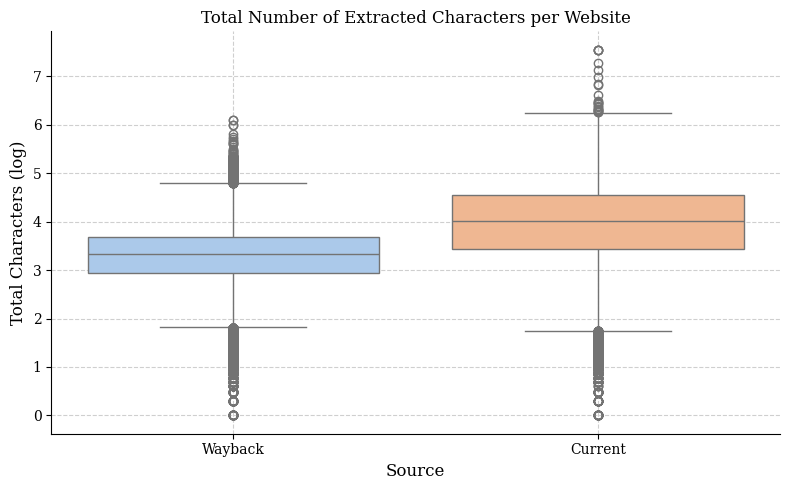

In [44]:
def plot_character_boxplot(df, wayback_column='wayback_total_text_len', current_column='current_total_text_len'):
    # Prepare and filter data
    df_plot = df[[wayback_column, current_column]].dropna().copy()
    df_plot = df_plot[(df_plot[wayback_column] > 0) & (df_plot[current_column] > 0)]

    # Melt for seaborn
    df_melted = df_plot.rename(columns={
        wayback_column: 'Wayback',
        current_column: 'Current'
    }).melt(var_name='Source', value_name='Total Characters')

    # Log10 transform
    df_melted['Total Characters'] = np.log10(df_melted['Total Characters'])

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.boxplot(x='Source', y='Total Characters', data=df_melted, hue='Source', palette='pastel', legend=False, ax=ax)

    ax.set_title('Total Number of Extracted Characters per Website')
    ax.set_ylabel('Total Characters (log)')
    ax.set_xlabel('Source')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

plot_character_boxplot(df)

## 1. Domain Word Analysis

In [43]:
from urllib.parse import urlparse
from unidecode import unidecode
from ftlangdetect import detect

with open(RAW_DATA_DIR / 'company_urls' / 'internal_urls.txt', 'r') as f:
    urls = [url for url in f.readlines()]

In [108]:
[url for url in urls if 'flash' in url]

['https://www.ses-shop.ch/led-lampenwelt/off-road-und-arbeitsleuchten/lazer-led-lichtbalken-triple-r-1000-mit-integriertem-flasher_7069_11685\n',
 'https://www.ses-shop.ch/led-lampenwelt/off-road-und-arbeitsleuchten/lazer-led-lichtbalken-triple-r-1000-mit-integriertem-flasher_7069_11686\n',
 'https://www.gore.com/resources/case-study-aluminum-oxide-catalyst-flash-dryer-filtering-using-gore-filter-bags\n',
 'https://www.gore.com/resources/gore-low-drag-filter-bags-case-study-tio2-flash-dryer\n',
 'https://www.hoerwerkstatt.ch/products/humantechnik-lisa-time-flash\n',
 'https://www.hoerwerkstatt.ch/products/humantechnik-lisa-rf-time-flash\n',
 'https://www.hoerwerkstatt.ch/fr/products/humantechnik-lisa-time-flash\n',
 'https://www.hoerwerkstatt.ch/fr/products/humantechnik-lisa-rf-time-flash\n',
 'https://discobed-europe.com/products/hydracell-aquaflash\n',
 'https://discobed-europe.com/en/products/hydracell-aquaflash\n',
 'https://discobed-europe.com/it/products/hydracell-aquaflash\n',
 

In [99]:
def normalize(text: str) -> str:
    text = text.replace('ä', 'ae').replace('ö', 'oe').replace('ü', 'ue')
    return unidecode(text.lower())

def detect_language(text: str) -> str:
    if 'ueber' in text:
        return 'de'
    return detect(text)['lang']

paths = [urlparse(url).path.strip('/') for url in urls]

level_1_paths = []
for path in paths:
    path_splits = path.split('/')
    if len(path_splits) >= 1 and len(path_splits[0]) > 2:
        level_1_paths.append(path_splits[0])
    elif len(path_splits) > 1 and len(path_splits[0]) <= 2:
        level_1_paths.append(path_splits[1])

level_1_paths = [normalize(path) for path in level_1_paths for path in path.split('-') if len(path) > 2]

# paths2lang = {path: detect_language(path) for path in paths}

In [101]:
len(level_1_paths)

206275

In [54]:
import spacy

nlp_en = spacy.load('en_core_web_sm')
nlp_de = spacy.load('de_core_news_sm')
nlp_fr = spacy.load('fr_core_news_sm')
nlp_it = spacy.load('it_core_news_sm')


def lemmatize(text, nlp):        
    return ''.join([word.lemma_ for word in nlp(text)])


english = [lemmatize(path, nlp_en) for path, lang in paths2lang.items() if lang == 'en']
german = [lemmatize(path, nlp_de) for path, lang in paths2lang.items() if lang == 'de']
french = [lemmatize(path, nlp_fr) for path, lang in paths2lang.items() if lang == 'fr']
italian = [lemmatize(path, nlp_it) for path, lang in paths2lang.items() if lang == 'it']

In [38]:
from wordcloud import WordCloud

In [102]:
from collections import Counter
frequencies = Counter(level_1_paths)

In [103]:
frequencies

Counter({'product': 9891,
         'produit': 7586,
         'flash': 7028,
         'events': 6215,
         'products': 5801,
         'produkt': 4874,
         'prodotto': 4425,
         'produto': 4339,
         'producto': 4062,
         'reservation': 3677,
         'listing': 3205,
         'news': 2762,
         'artikel': 2454,
         'faculty': 2398,
         'salon': 2304,
         'search': 2222,
         'led': 2145,
         'resources': 2123,
         'konzerte': 1653,
         'portfolio': 1605,
         'fille': 1310,
         'item': 1250,
         'blog': 1221,
         'market': 1214,
         'posts': 1201,
         'pulse': 1201,
         'category': 1185,
         'reflexion': 1109,
         'shop': 1074,
         'objekt': 1030,
         'page': 978,
         'systeme': 974,
         'categoria': 899,
         'html5': 851,
         'tag': 845,
         'produits': 837,
         'agilite': 830,
         'action': 827,
         'marken': 816,
         'departme

In [104]:
wordcloud = WordCloud().generate_from_frequencies(dict(frequencies))

(-0.5, 399.5, 199.5, -0.5)

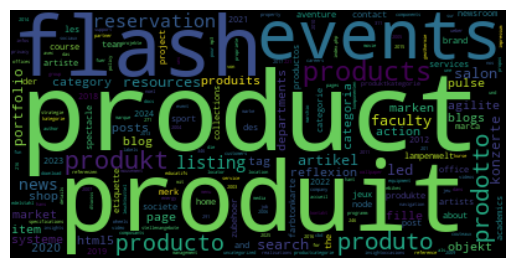

In [106]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")